In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import matplotlib;
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns; sns.set_theme(color_codes=True)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.animation import FuncAnimation
import lightgbm as lgb

import re
import os
import time
import io
import argparse

def check_directory_exists(directory):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory '{directory}' does not exist.")

def get_date(file_name):
    date_pattern = r'\d{8}'  # Matches 8 digits (YYYYMMDD)
    match = re.search(date_pattern, file_name)
    if match:
        date_str = match.group()
        return date_str
    else:
        return np.nan

def get_files(start_date, end_date):
    filename_list = []

    while start_date <= end_date:
        filename = f'QR_TAKEHOME_{str(start_date.strftime("%Y%m%d"))}.csv.parquet'
        filename_list.append(filename)
        start_date += timedelta(days=1)

    return filename_list

def get_data(start_date, end_date, directory='/Projects/ClearStreet/qr_takehome', period='morning'):
    
    check_directory_exists(directory)
    
    morning_df = pd.DataFrame()
    midday_df = pd.DataFrame()
    afternoon_df = pd.DataFrame()

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    filename_list = get_files(start_date, end_date)

    for filename in filename_list:
        filepath = os.path.join(directory, filename)
        if not os.path.exists(filepath):
            continue

        parquet_table = pq.read_table(filepath)
        df_datewise = parquet_table.to_pandas()
        df_datewise['date'] = pd.to_datetime(get_date(filename), format='%Y%m%d')

        morning_df = pd.concat([morning_df, df_datewise.loc[df_datewise['time'] <= 39600000].sort_values(by='time')], ignore_index=True)
        midday_df = pd.concat([midday_df, df_datewise.loc[(df_datewise['time'] >= 39601000) & (df_datewise['time'] <= 50400000)].sort_values(by='time')], ignore_index=True)
        afternoon_df = pd.concat([afternoon_df, df_datewise.loc[(df_datewise['time'] >= 50401000)].sort_values(by='time')], ignore_index=True)

    df = morning_df

    if period == 'midday':
        df = midday_df
    elif period == 'afternoon':
        df = afternoon_df

    df['time'] = pd.to_timedelta(df['time'], unit='ms')
    df['datetime'] = df['date'] + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'])

    return df

def handle_nan(data, outlier_col='Y'):
    df = data.loc[data['Q1']>=0.99].loc[data['Q2']>=0.99]
    df.replace(999999, np.nan, inplace=True)
    df = df.dropna(thresh=int(0.5 * df.shape[1]))
    df.reset_index(inplace=True, drop=True)

    numeric_columns = df.select_dtypes(include=['number']).columns
    columns_to_interpolate = [col for col in numeric_columns if col not in ['date', 'time', 'datetime']]
    df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear')

    percentile_low = 0.001
    percentile_high = 0.999

    max_val = df.groupby('date')[outlier_col].transform(lambda x: x.quantile(percentile_high))
    min_val = df.groupby('date')[outlier_col].transform(lambda x: x.quantile(percentile_low))
    df[outlier_col] = np.where((df[outlier_col] > min_val) & (df[outlier_col] < max_val), df[outlier_col], np.nan)
    df = df.dropna().reset_index(drop=True)

    return df
    

def get_top_features(df):
    scaler = StandardScaler()

    X = scaler.fit_transform(df[[f'X{i}' for i in range(1, 376)]])
    Y = scaler.fit_transform(df['Y'].values.reshape(-1, 1))

    param_grid = {
      'n_estimators': [100, 200],
      'learning_rate': [0.1, 0.05, 0.01],
      'max_depth': [3, 4, 5],
      'max_features': ['sqrt']
    }

    n_splits = 3
    tscv = TimeSeriesSplit(n_splits=n_splits)

    gbm = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=tscv, n_jobs=-1)
    Y = np.ravel(Y)
    grid_search.fit(X, Y)

    importances = grid_search.best_estimator_.feature_importances_
    importances_df = pd.DataFrame({'Feature': [f'X{i}' for i in range(1, 376)], 'Importances': importances})
    importances_df.sort_values(by='Importances', inplace=True, ascending=False)

    return handle_multicollinearity(df, importances_df)

def handle_multicollinearity(df, importances_df, threshold=0.7):
    imp_columns = importances_df.head(100)['Feature']
    X = df[imp_columns]
    corr_matrix = X.corr()

    high_corr_dict = {}
    for col in corr_matrix.columns:
        high_corr_cols = [c for c in corr_matrix.columns if c != col and abs(corr_matrix.loc[col, c]) > threshold]
        high_corr_dict[col] = high_corr_cols

    imp_columns = importances_df.head(100)['Feature']
    skipped = set()
    new_features = []
    for imp_col in imp_columns:
        if imp_col in skipped:
            continue
        new_features.append(imp_col)
        for coll in high_corr_dict[imp_col]:
            skipped.add(coll)
    return new_features

def modified_timeseries_model(time_series_data):
    independent_cols = [col for col in time_series_data.columns if col not in ['Y', 'datetime']]
    time_series_model = sm.OLS(time_series_data['Y'], time_series_data[independent_cols]).fit()
    print('Time series model summary', flush=True)
    print(time_series_model.summary(), flush=True)
    return time_series_model, independent_cols

def regression_model(time_series_data, independent_cols):
    model = sm.OLS(time_series_data['Y'], time_series_data[independent_cols]).fit()
    print('Model summary', flush=True)
    print(model.summary(), flush=True)
    return model

def get_timeseries_data(df, imp_columns, y='Y1'):
    scaler = StandardScaler()
    time_series_data = df[imp_columns].copy()
    time_series_data[imp_columns] = scaler.fit_transform(time_series_data[imp_columns])
    time_series_data['Y'] = scaler.fit_transform(df['Y'].values.reshape(-1, 1))
    time_series_data['datetime'] = df['datetime']

    if y == 'Y2':
        time_series_data['Y_lag_2'] = time_series_data['Y'].shift(1)

    time_series_data['Y_lag_1'] = time_series_data['Y'].shift(1)
    time_series_data['Y_lag_301'] = time_series_data['Y'].shift(301)
    return time_series_data#[301:].reset_index(drop=True)

# Function to update the plot
def update(frame, ax, test, y_pred, lines, max_display_points=500):
    predictions, actual, time_p, time_a = lines

    if frame < len(test):
        new_time = test.iloc[frame]['datetime']
        predictions.append(y_pred[frame])
        time_p.append(new_time)

        if len(predictions) > max_display_points:
            predictions.pop(0)
            time_p.pop(0)
            actual.pop(0)
            time_a.pop(0)

    ax.clear()
    ax.plot(time_p, predictions, color='maroon', alpha=0.7, label='Predictions')
    ax.plot(time_a, actual, color='darkgreen', alpha=0.7, label='Real time record')
    ax.set_title('Real-Time Calibrations')
    ax.set_xlabel('Time')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')
    
    new_actual = test.iloc[frame]['Y']
    actual.append(new_actual)
    time_a.append(new_time)

def calibration_plot(test, model, independent_cols):
    fig, ax = plt.subplots(figsize=(10, 6))
    predictions, actual, time_p, time_a = [], [], [], []
    y_pred = model.predict(test[independent_cols])

    anim = FuncAnimation(fig, update, frames=len(test), fargs=(ax, test, y_pred, (predictions, actual, time_p, time_a)),
                         interval=10, blit=False, repeat=False)

    plt.show()
    return anim

def train_test_split(data_to_split, split_date):
    split_date = pd.to_datetime(split_date)
    train, test = data_to_split.loc[data_to_split['datetime'] <= split_date], data_to_split.loc[data_to_split['datetime'] > split_date]
    return train, test

def get_main_args():
    print('Parsing Arguments config file', flush=True)
    parser = argparse.ArgumentParser(description="This is the calibration module, please ensure your settings for teh script have been specified in the config file")
    parser.add_argument("--config", type=str, default='config.json', help="Config file path")

    args = parser.parse_args()

    # Load configuration settings from the JSON file
    with open(args.config, 'r') as config_file:
        config = json.load(config_file)
    start_date = config.get('start_date', '2022-01-01')
    end_date = config.get('end_date', '2022-03-31')
    split_date = config.get('split_date', '2022-03-12')
    period = config.get('period', 'morning')
    directory = config.get('directory', '/Projects/ClearStreet/qr_takehome')
    hardcode_imp_features = config.get('hardcode_imp_features', True)
    Y = config.get('Y', 'Y1')
    
    return start_date, end_date, split_date, period, directory, hardcode_imp_features, Y

In [23]:
start_date = '2022-01-01'
end_date = '2022-03-31'
split_date = '2022-03-12'
period = 'morning'
directory = '/Projects/ClearStreet/qr_takehome'
hardcode_imp_features = True
Y = 'Y1'

data = get_data(start_date, end_date, directory, period)

if Y == 'Y1':
    data.rename(columns={'Y1': 'Y'}, inplace=True)
    data.drop(columns=['Y2'], inplace=True)
elif Y == 'Y2':
    data.rename(columns={'Y2': 'Y'}, inplace=True)
    data.drop(columns=['Y1'], inplace=True)

print('Handling NaN...', flush=True)
data = handle_nan(data)
train, test = train_test_split(data, split_date)

Handling NaN...


Just trying different things below to see which columns are most relevant, most data here seems pretty noisy.
- Trying to find relevance using stepwise regressions
- LASSO done earlier didnt give any good results
- Picking top 100 and bottom 100 (top negative correlations) and visualizing scatter plots to see any predictable patterns

In [36]:
scaler = StandardScaler()
elements = []
for i in range(1, 376):
    variable = f'X{i}'
    x = scaler.fit_transform(train[variable].values.reshape(-1, 1)).ravel()
    y = scaler.fit_transform(train['Y'].values.reshape(-1, 1)).ravel()
    #y = (1 + y - y.min())
    #y = np.log(y)
    model = sm.OLS(y, x).fit()
    elements.append((variable, model.rsquared, model.fvalue, model.tvalues[0]))
stats_df = pd.DataFrame(elements, columns=['Variable', 'R-squared', 'F-stat', 'T-stat'])
stats_df.sort_values(by='R-squared', ascending=False)[:100]

Variable  R-squared       F-stat     T-stat
94       X95   0.048214  1128.272348 -33.589718
74       X75   0.045943  1072.577744 -32.750195
75       X76   0.044339  1033.388658 -32.146355
64       X65   0.042264   982.889295 -31.351051
252     X253   0.040594   942.406906  30.698700
54       X55   0.034091   786.096367 -28.037388
95       X96   0.032439   746.744145 -27.326708
76       X77   0.030249   694.748800 -26.358063
371     X372   0.024236   553.215511 -23.520557
232     X233   0.023960   546.764067  23.382999
96       X97   0.021405   487.186207 -22.072245
229     X230   0.020524   466.704497 -21.603346
65       X66   0.020274   460.910216 -21.468779
77       X78   0.019670   446.909902 -21.140280
48       X49   0.017584   398.650347 -19.966242
104     X105   0.016848   381.681214 -19.536690
335     X336   0.016693   378.103390 -19.444994
120     X121   0.016635   376.772348  19.410557
140     X141   0.015963   361.310205  19.008276
272     X273   0.015566   352.189358 -18.766712

In [3]:
temp = train[['Y'] + [f'X{i}' for i in range(1, 376)]].copy()
scaler = StandardScaler()
for col in temp.columns:
    temp[col] = scaler.fit_transform(temp[col].values.reshape(-1,1)).ravel()
corr_matrix = temp.corr()

In [4]:
top = pd.DataFrame()
top['top_100'] = (corr_matrix['Y'].sort_values(ascending=False)[1:101]).index
top['bot_100'] = (corr_matrix['Y'].sort_values(ascending=True)[:100]).index
top

top_100 bot_100
0     X121    X205
1     X141    X313
2     X234    X176
3     X233    X204
4     X122    X177
..     ...     ...
95     X79    X218
96    X300     X74
97    X157    X210
98    X153    X346
99    X149    X342

[100 rows x 2 columns]

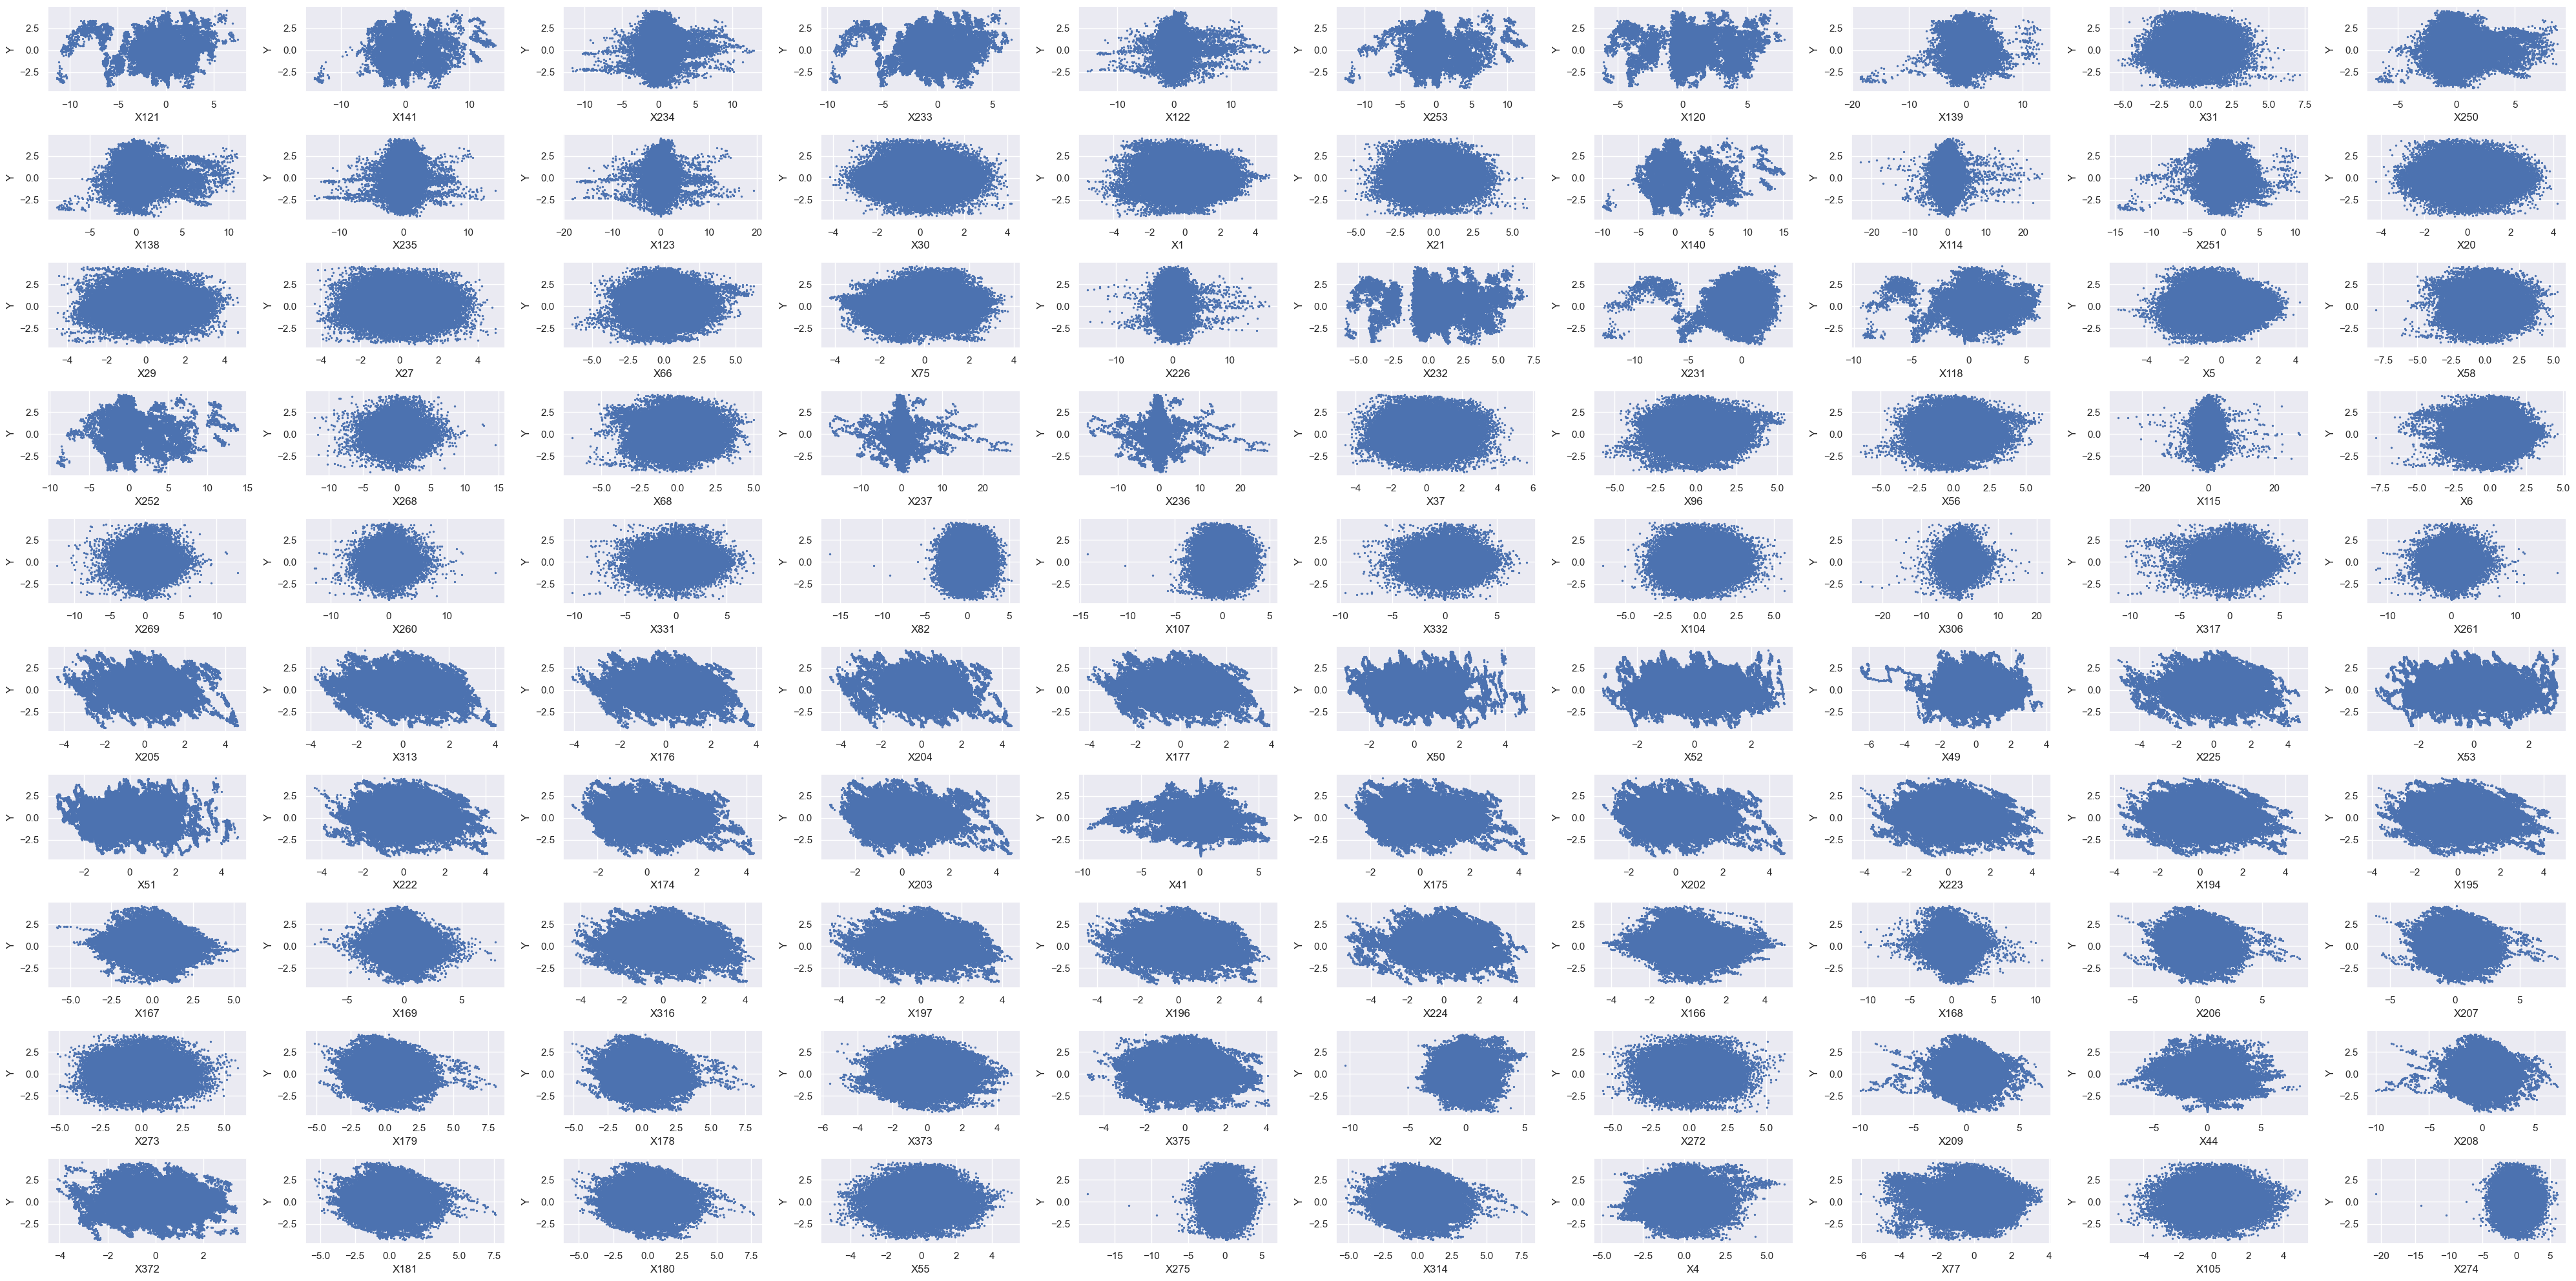

In [12]:
# Create a 10x20 subplot grid
fig, axes = plt.subplots(10, 10, figsize=(40, 20))

# Flatten the axes array to iterate through it
axes = axes.flatten()

# Loop through each subplot and plot a scatter plot
for i in range(len(axes)):
    col = 'X0'
    if i < 50:
        col = top.iloc[i]['top_100']
    else:
        col = top.iloc[i-50]['bot_100']
    
    axes[i].scatter(temp[col], temp['Y'], s=2)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Y')

# Adjust spacing and show the plots
plt.tight_layout()
plt.show()

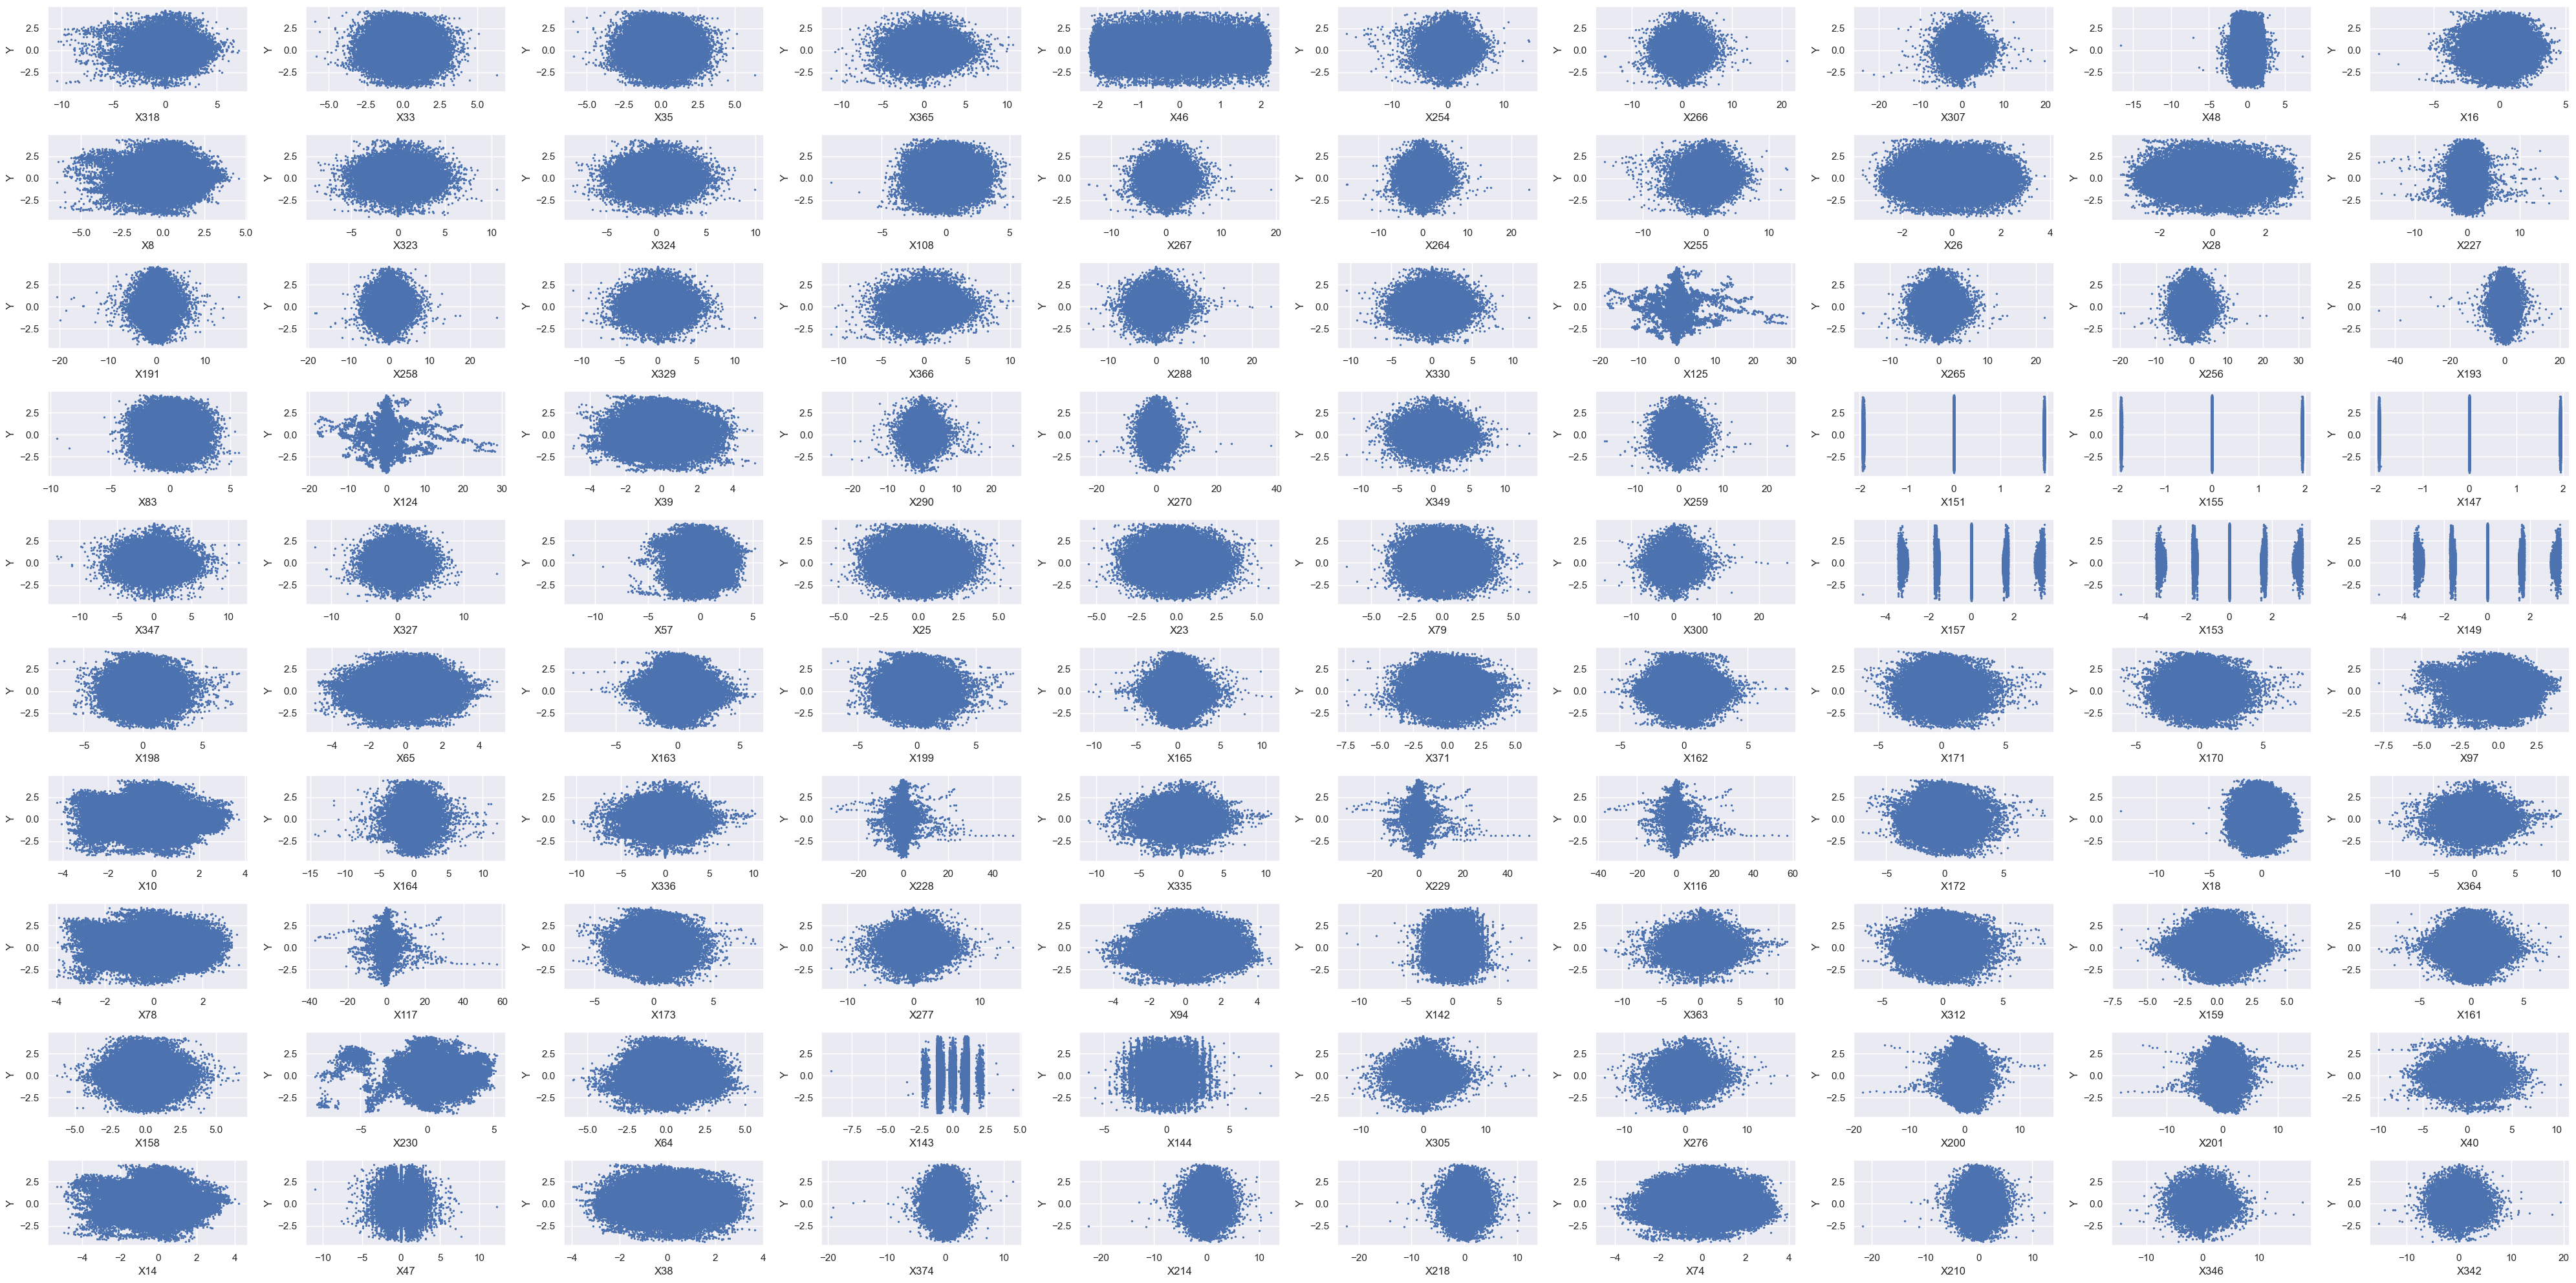

In [11]:
# Create a 10x20 subplot grid
fig, axes = plt.subplots(10, 10, figsize=(40, 20))

# Flatten the axes array to iterate through it
axes = axes.flatten()

# Loop through each subplot and plot a scatter plot
for i in range(len(axes)):
    col = 'X0'
    idx = 50 + i
    if i < 50:
        col = top.iloc[idx]['top_100']
    else:
        col = top.iloc[idx-50]['bot_100']
    
    axes[i].scatter(temp[col], temp['Y'], s=2)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Y')

# Adjust spacing and show the plots
plt.tight_layout()
plt.show()

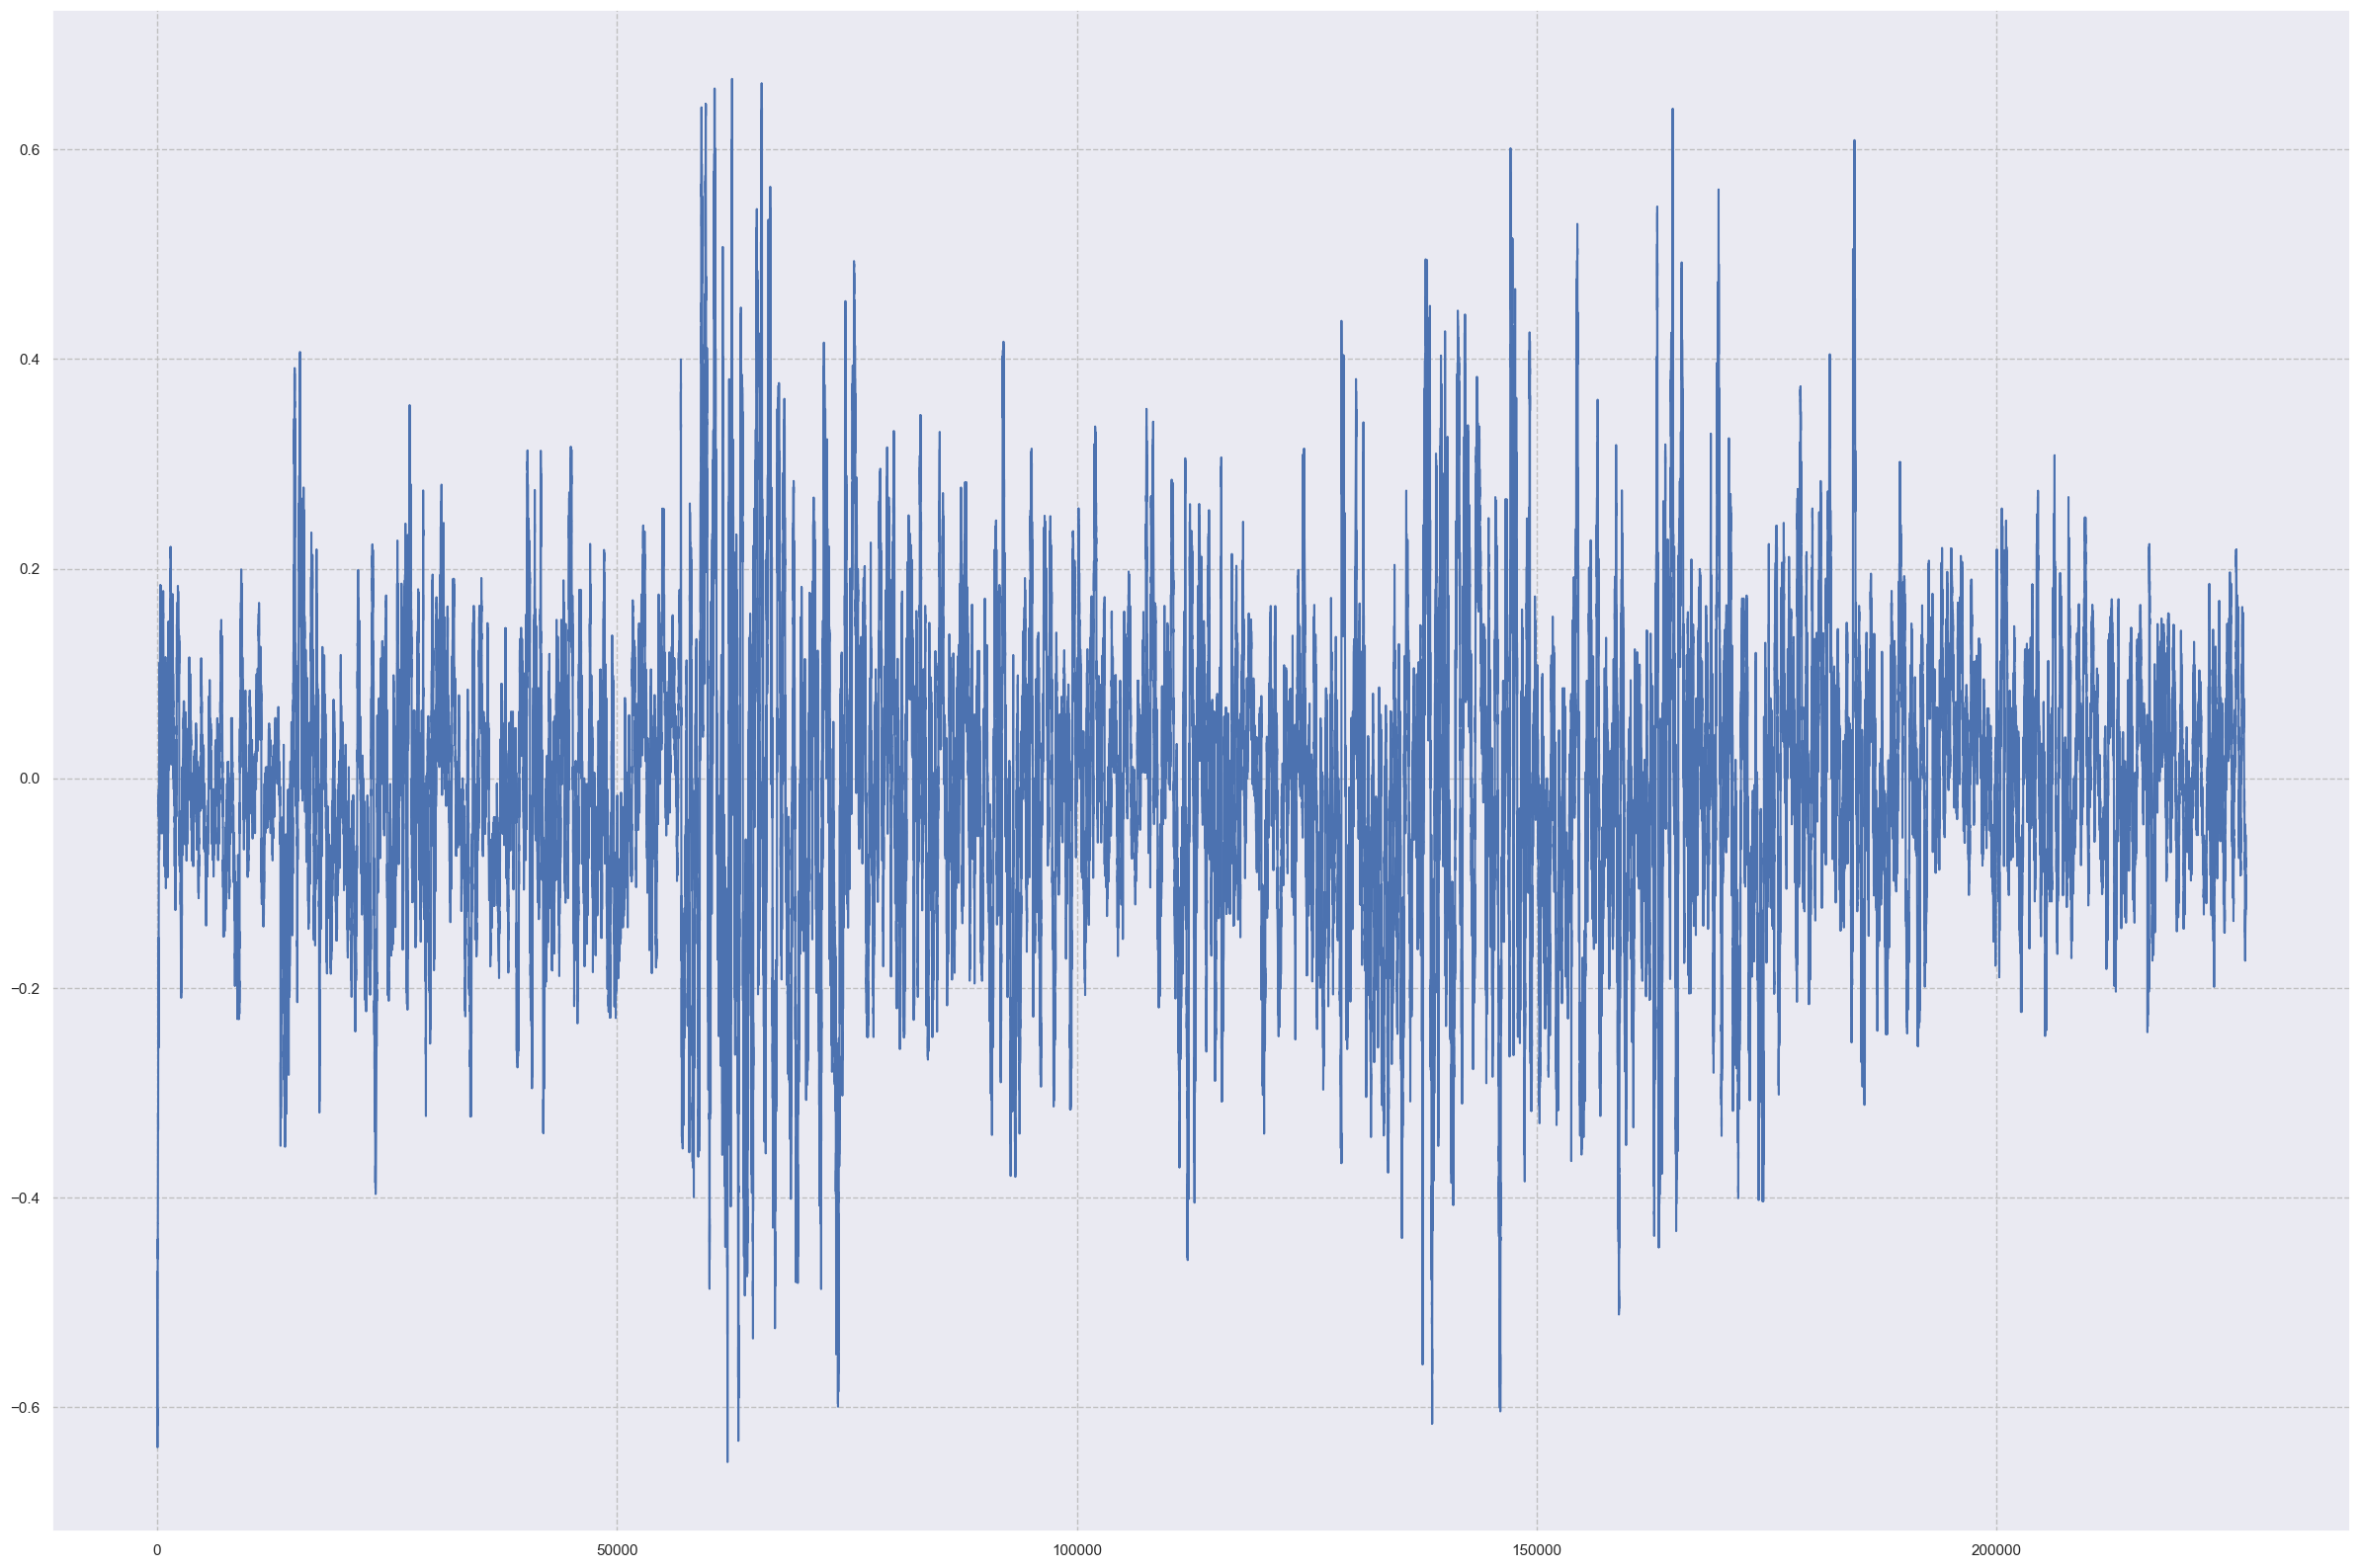

In [24]:
plt.figure(figsize=(30,20))
plt.grid(linestyle='--', color='silver')
plt.plot((data['Y'] * 0.01))

In [111]:
high_corr_cols = ['X121', 'X141', 'X234', 'X122', 'X114', 'X120', 'X139', 'X128', 'X30', 'X235', 'X232']  # most meaningful +vely correlated cols that are common using multiple feature selection processes
low_corr_cols = ['X205', 'X41', 'X53', 'X169', 'X273', 'X153',] # most meaningful -vely correlated cols from scatterplot analysis and other methods
imp_df = pd.DataFrame( {'Feature': (high_corr_cols + low_corr_cols)})
cols_to_process = handle_multicollinearity(train, imp_df) #[f'X{i}' for i in range(1, 376)] 
temp = train[['datetime', 'Y'] + cols_to_process].copy()
temp['datetime'] = pd.to_datetime(temp['datetime'])
temp = temp.set_index('datetime')
print(len(temp.columns))
temp

15


Y      X121      X141      X234      X114  \
datetime                                                                 
2022-01-03 09:45:01 -49.671906 -0.248765 -0.151333  0.023855 -0.065699   
2022-01-03 09:45:02 -48.895279 -0.541802 -0.444742 -0.885036 -0.918287   
2022-01-03 09:45:03 -47.067436 -0.247763 -0.151126 -0.894530 -0.874573   
2022-01-03 09:45:04 -47.590408  0.000000  0.000000 -0.084250 -0.060552   
2022-01-03 09:45:05 -48.110863  0.000000  0.000000  0.236589  0.000000   
...                        ...       ...       ...       ...       ...   
2022-03-11 10:59:56 -16.965513 -0.127980  0.000000 -0.501971 -0.351096   
2022-03-11 10:59:57 -16.088928 -0.503979 -0.120022 -0.668858 -0.490661   
2022-03-11 10:59:58 -15.796402 -0.152113  0.000000 -0.292920 -0.110279   
2022-03-11 10:59:59 -14.042890 -0.483737 -0.101198 -1.008769 -0.782051   
2022-03-11 11:00:00 -14.042890 -0.365065  0.000000 -0.991609 -0.423667   

                         X120      X139      X128       X30       X205  X41  \
datetime                                                                      
2022-01-03 09:45:01  0.000000  0.000000 -0.622514 -0.129597  10.694881  0.0   
2022-01-03 09:45:02  0.132091 -0.650055  0.000000 -0.025432   9.304647  0.0   
2022-01-03 09:45:03  0.949864 -0.689427  0.077676 -0.025953   8.480295  0.0   
2022-01-03 09:45:04  1.211052  0.000000  0.176622  0.011245   8.212002  0.0   
2022-01-03 09:45:05  1.127890  0.150209  0.232754  0.062984   8.287782  0.0   
...                       ...       ...       ...       ...        ...  ...   
2022-03-11 10:59:56  0.000000 -0.536436 -0.153419  0.098596  19.286434  0.0   
2022-03-11 10:59:57  0.000000 -0.761341  0.000000  0.079804  18.828665  0.0   
2022-03-11 10:59:58  0.000000 -0.270484  0.000000 -0.019560  18.579683  0.0   
2022-03-11 10:59:59  0.000000 -1.000583  0.000000 -0.038397  17.844013  0.0   
2022-03-11 11:00:00  0.000000 -1.077563  0.000000  0.064244  17.828981  0.0   

                          X53      X169      X273          X153  
datetime                                                         
2022-01-03 09:45:01 -0.316130 -0.001776  0.000000  0.000000e+00  
2022-01-03 09:45:02 -0.322558 -0.006469  0.000000  0.000000e+00  
2022-01-03 09:45:03 -0.325545 -0.007735  0.000000  0.000000e+00  
2022-01-03 09:45:04 -0.323086 -0.007378  0.000000  4.513049e-01  
2022-01-03 09:45:05 -0.317987 -0.006830  0.000000  0.000000e+00  
...                       ...       ...       ...           ...  
2022-03-11 10:59:56  0.448482  0.020483 -0.589748  0.000000e+00  
2022-03-11 10:59:57  0.445591  0.018946 -0.762841  0.000000e+00  
2022-03-11 10:59:58  0.446780  0.018539 -0.389610  0.000000e+00  
2022-03-11 10:59:59  0.444116  0.016367 -1.114886  0.000000e+00  
2022-03-11 11:00:00  0.442846  0.016213 -1.106857 -1.883188e-14  

[178262 rows x 15 columns]

In [79]:
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X = x_scaler.fit_transform(temp.drop('Y', axis=1))
y = y_scaler.fit_transform(temp['Y'].values.reshape(-1, 1)).ravel()
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200]
}
model = lgb.LGBMRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='r2')
grid_search.fit(X, y)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 29712, number of used features: 14
[LightGBM] [Info] Start training from score -0.066062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 59422, number of used features: 14
[LightGBM] [Info] Start training from score -0.031310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 89132, number of used features: 14
[LightGBM] [Info] Start t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 148552, number of used features: 14
[LightGBM] [Info] Start training from score 0.018824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 29712, number of used features: 14
[LightGBM] [Info] Start training from score -0.066062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 59422, number of used features: 14
[LightGBM] [Info] Start t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 118842, number of used features: 14
[LightGBM] [Info] Start training from score 0.023542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 148552, number of used features: 14
[LightGBM] [Info] Start training from score 0.018824
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 29712, number of used features: 14
[LightGBM] [Info] Start t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 89132, number of used features: 14
[LightGBM] [Info] Start training from score 0.009802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 118842, number of used features: 14
[LightGBM] [Info] Start training from score 0.023542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 148552, number of used features: 14
[LightGBM] [Info] Start t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 59422, number of used features: 14
[LightGBM] [Info] Start training from score -0.031310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 89132, number of used features: 14
[LightGBM] [Info] Start training from score 0.009802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 118842, number of used features: 14
[LightGBM] [Info] Start t

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 29712, number of used features: 14
[LightGBM] [Info] Start training from score -0.066062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 59422, number of used features: 14
[LightGBM] [Info] Start training from score -0.031310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 89132, number of used features: 14
[LightGBM] [Info] Start t

In [97]:
# Assuming you have 'temp' as your DataFrame with features
X = temp.drop('Y', axis=1).values
y = temp['Y'].values.reshape(-1, 1)  # Reshape y to (samples, 1)

# Standardize your features
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

# Split your data into train and test (or use cross-validation)
tscv = TimeSeriesSplit(n_splits=5)

# Define your LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define lists to store results
best_scores = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape data for LSTM (samples, timesteps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Fit the LSTM model
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Make predictions and inverse transform
    y_pred = model.predict(X_test)
    
    # Calculate R-squared for this fold
    r2 = r2_score(y_test, y_pred)

    # Append results to lists
    best_scores.append(r2)

# Find the fold with the best R-squared score
best_fold = np.argmax(best_scores)
best_score_final = best_scores[best_fold]

print("Best R-squared score:", best_score_final)

Epoch 1/50
929/929 [==============================] - 23s 18ms/step - loss: 112.4654
Epoch 2/50
929/929 [==============================] - 20s 22ms/step - loss: 109.9138
Epoch 3/50
929/929 [==============================] - 17s 19ms/step - loss: 107.8551
Epoch 4/50
929/929 [==============================] - 17s 19ms/step - loss: 105.6871
Epoch 5/50
929/929 [==============================] - 18s 19ms/step - loss: 103.5777
Epoch 6/50
929/929 [==============================] - 17s 19ms/step - loss: 101.9548
Epoch 7/50
929/929 [==============================] - 17s 18ms/step - loss: 100.3198
Epoch 8/50
929/929 [==============================] - 17s 19ms/step - loss: 99.1726
Epoch 9/50
929/929 [==============================] - 17s 18ms/step - loss: 97.8922
Epoch 10/50
929/929 [==============================] - 17s 18ms/step - loss: 96.9633
Epoch 11/50
929/929 [==============================] - 17s 19ms/step - loss: 95.2970
Epoch 12/50
929/929 [==============================] - 17s 18ms/ste

1857/1857 [==============================] - 35s 19ms/step - loss: 84.1722
Epoch 46/50
1857/1857 [==============================] - 33s 18ms/step - loss: 83.8281
Epoch 47/50
1857/1857 [==============================] - 33s 18ms/step - loss: 83.9874
Epoch 48/50
1857/1857 [==============================] - 34s 18ms/step - loss: 83.9636
Epoch 49/50
1857/1857 [==============================] - 33s 18ms/step - loss: 84.4460
Epoch 50/50
929/929 [==============================] - 5s 6ms/step
Epoch 1/50
2786/2786 [==============================] - 50s 18ms/step - loss: 182.6080
Epoch 2/50
2786/2786 [==============================] - 50s 18ms/step - loss: 176.0391
Epoch 3/50
2786/2786 [==============================] - 50s 18ms/step - loss: 172.3997
Epoch 4/50
2786/2786 [==============================] - 50s 18ms/step - loss: 169.7511
Epoch 5/50
2786/2786 [==============================] - 50s 18ms/step - loss: 168.0042
Epoch 6/50
2786/2786 [==============================] - 50s 18ms/step - los

3714/3714 [==============================] - 67s 18ms/step - loss: 142.4110
Epoch 38/50
3714/3714 [==============================] - 67s 18ms/step - loss: 142.6790
Epoch 39/50
3714/3714 [==============================] - 69s 19ms/step - loss: 142.5538
Epoch 40/50
3714/3714 [==============================] - 67s 18ms/step - loss: 141.9404
Epoch 41/50
3714/3714 [==============================] - 67s 18ms/step - loss: 142.0636
Epoch 42/50
3714/3714 [==============================] - 67s 18ms/step - loss: 141.4774
Epoch 43/50
3714/3714 [==============================] - 67s 18ms/step - loss: 141.5524
Epoch 44/50
3714/3714 [==============================] - 67s 18ms/step - loss: 141.4918
Epoch 45/50
3714/3714 [==============================] - 67s 18ms/step - loss: 140.6700
Epoch 46/50
3714/3714 [==============================] - 67s 18ms/step - loss: 141.6905
Epoch 47/50
3714/3714 [==============================] - 67s 18ms/step - loss: 140.9437
Epoch 48/50
3714/3714 [=====================

5571/5571 [==============================] - 31s 6ms/step


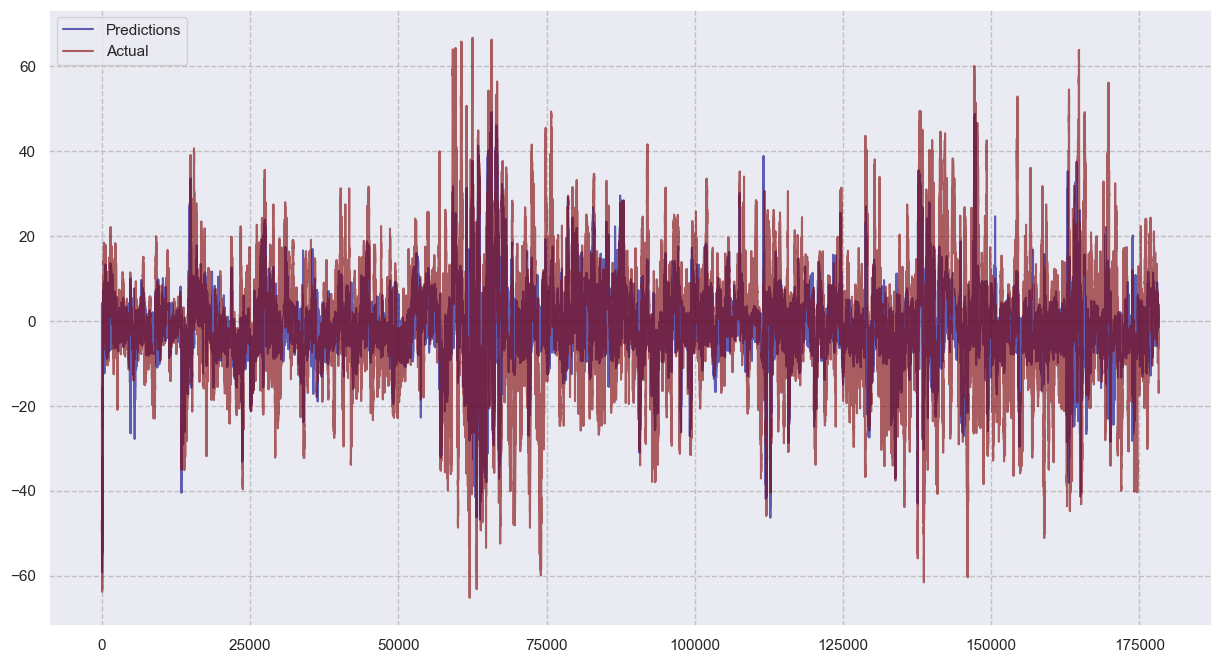

In [113]:
X = temp.drop('Y', axis=1).values
y = temp['Y'].values.reshape(-1, 1)  # Reshape y to (samples, 1)
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
X_plot =  np.reshape(X, (X.shape[0], X.shape[1], 1))
y_pred = model.predict(X_plot)#grid_search.predict(X) 
plt.figure(figsize=(15,8))
plt.grid(linestyle='--', color='silver')
plt.plot(y_pred, label='Predictions', alpha=0.6, color='darkblue')
plt.plot(y, alpha=0.6, label='Actual', color='maroon')
plt.legend()

### Out of sample Test

In [107]:
high_corr_cols = ['X121', 'X141', 'X234', 'X122', 'X114', 'X120', 'X139', 'X128', 'X30', 'X235', 'X232']  # most meaningful +vely correlated cols that are common using multiple feature selection processes
low_corr_cols = ['X205', 'X41', 'X53', 'X169', 'X273', 'X153',] # most meaningful -vely correlated cols from scatterplot analysis and other methods
imp_df = pd.DataFrame( {'Feature': (high_corr_cols + low_corr_cols)})
cols_to_process = handle_multicollinearity(train, imp_df) #[f'X{i}' for i in range(1, 376)] 
temp = test[['datetime', 'Y'] + cols_to_process].copy()
temp['datetime'] = pd.to_datetime(temp['datetime'])
temp = temp.set_index('datetime')

1528/1528 [==============================] - 10s 6ms/step


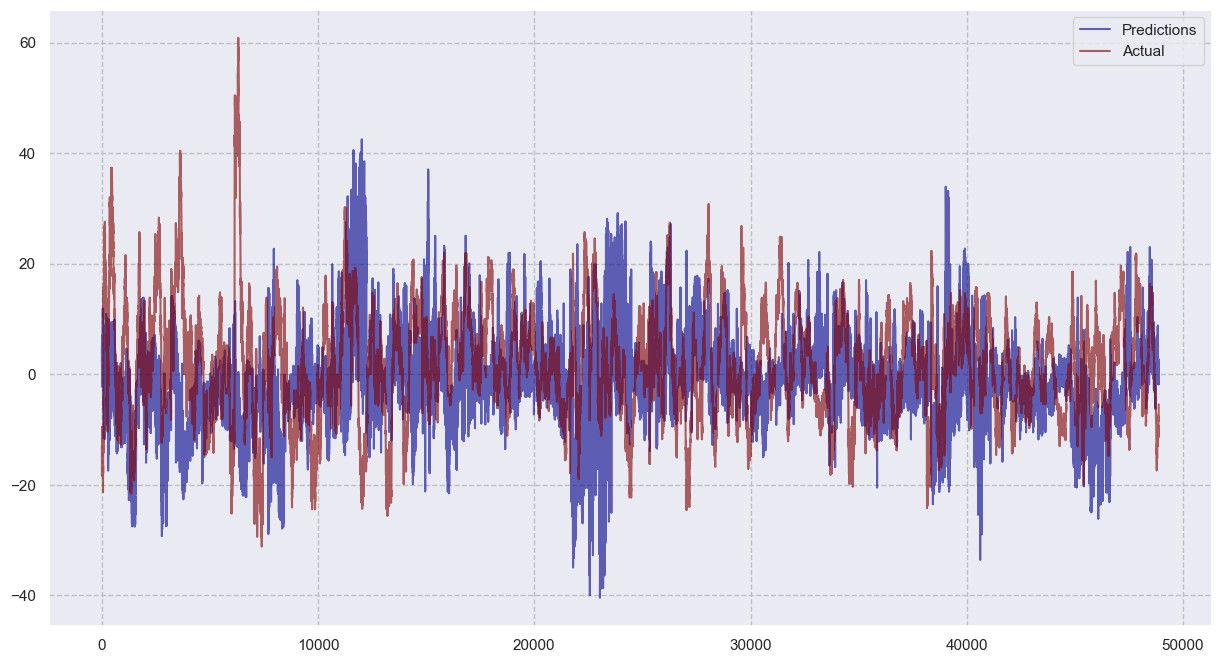

In [109]:
X = temp.drop('Y', axis=1).values
y = temp['Y'].values.reshape(-1, 1)  # Reshape y to (samples, 1)
x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)
X_plot =  np.reshape(X, (X.shape[0], X.shape[1], 1))
y_pred = model.predict(X_plot)#grid_search.predict(X) 
plt.figure(figsize=(15,8))
plt.grid(linestyle='--', color='silver')
plt.plot(y_pred, label='Predictions', alpha=0.6, color='darkblue')
plt.plot(y, alpha=0.6, label='Actual', color='maroon')
plt.legend()